In [1]:
import os
from pandas import read_csv

In [2]:
os.chdir('./trainData')

In [5]:
data = read_csv('articles1.csv',nrows=30000)

In [6]:
data.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [7]:
data = data[['title','content']][data['content'].apply(lambda x : len(x)>20 )]

In [8]:
data.shape

(29964, 2)

In [9]:
headline = list(data['title'].apply(lambda x :  'sos '+ x ))
body = list(data['content'].apply(lambda x:x.split()[:100]))



In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(body,headline,test_size=0.1,random_state=0,shuffle=True) 

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [12]:
tokenizer = Tokenizer(filters='!"#$%&()*+,\'-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(x_train + y_train)

In [13]:
word_to_index=tokenizer.word_index
index_to_word={ index:word for word,index in word_to_index.items()}
vocab_size=len(word_to_index)
print(vocab_size)

130743


In [14]:
eosIndex = 0
eosTag = 'eos'
word_to_index[eosTag] = eosIndex
index_to_word[eosIndex] = eosTag


In [15]:
train_sequence_text=tokenizer.texts_to_sequences(x_train)
train_sequence_head=tokenizer.texts_to_sequences(y_train)

In [16]:
test_sequence_text=tokenizer.texts_to_sequences(x_test)
test_sequence_head=tokenizer.texts_to_sequences(y_test)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

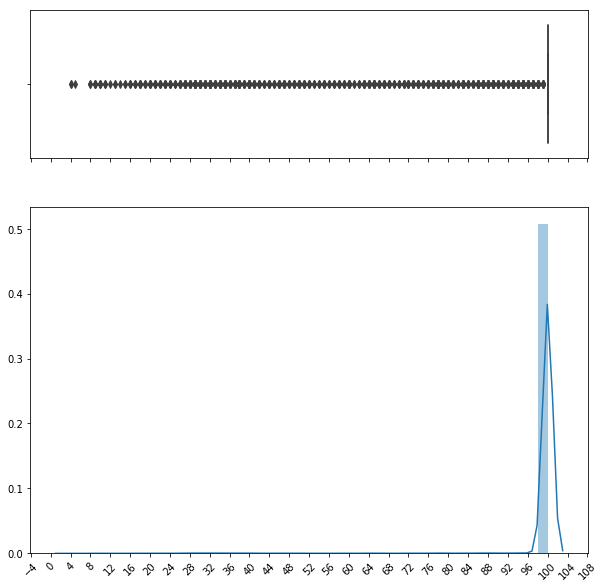

In [18]:

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(10,10), gridspec_kw={"height_ratios": (.30, .70)})
ax_hist.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(fontsize=10, rotation=45)

tmp  = [len(i) for i in train_sequence_text]
sns.boxplot(tmp, ax=ax_box)
sns.distplot(tmp, ax=ax_hist)
plt.show()

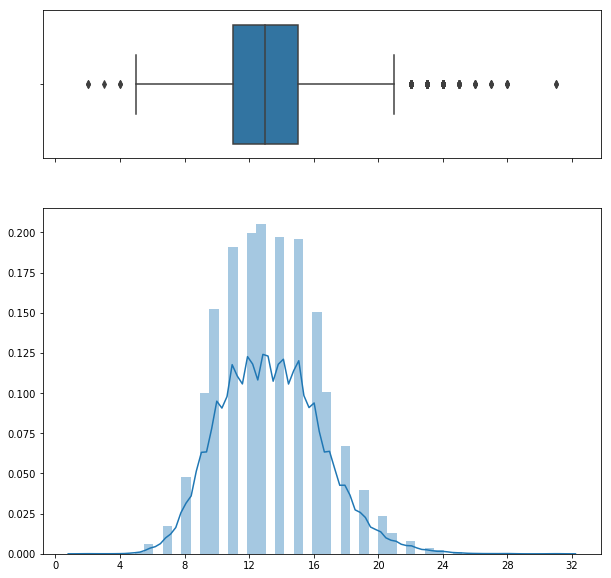

In [19]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(10,10), gridspec_kw={"height_ratios": (.30, .70)})
ax_hist.xaxis.set_major_locator(plt.MaxNLocator(10))
tmp  = [len(i) for i in train_sequence_head]
sns.boxplot(tmp, ax=ax_box)
sns.distplot(tmp, ax=ax_hist)

In [20]:
maxlen_x = 70
maxlen_y = 14
print(maxlen_x,maxlen_y)

70 14


In [21]:
x_tr = pad_sequences(train_sequence_text,  maxlen=maxlen_x, padding='post',truncating = 'post')
x_te = pad_sequences(test_sequence_text,  maxlen=maxlen_x, padding='post',truncating = 'post')


In [22]:
y_tr = pad_sequences(train_sequence_head,  maxlen=maxlen_y, padding='post',truncating = 'post')
y_te = pad_sequences(test_sequence_head,  maxlen=maxlen_y, padding='post',truncating = 'post')

In [23]:
from numpy import zeros,append

In [24]:
y_tr = append(y_tr, zeros((len(y_tr),1),dtype='int32') , axis=1)
y_te = append(y_te, zeros((len(y_te),1),dtype='int32') , axis=1)

In [25]:
y_tr[:5]

array([[    10,   4585,    329,   1114,      7,   1811,     21,    913,
           701,      2,   4170,    146,      0,      0,      0],
       [    10,   2339,   5879,      7,    176,     39,    152,  24864,
          5850,   2587,   4586,   6328,      0,      0,      0],
       [    10,    883,    916,    164,   8805,   1088,     15,   3264,
         15760,   1661,      0,      0,      0,      0,      0],
       [    10,    570,   3895,    199,   2441, 123367,      8,    406,
          3938,   2241,     11,    116,   7179,     62,      0],
       [    10,    986,  16235,  28518,   7470,     29,   6426,    103,
             0,      0,      0,      0,      0,      0,      0]],
      dtype=int32)

In [26]:
os.chdir('..')

In [27]:
from numpy import random,empty,sqrt

In [28]:
embedding_dim=200
embedding_weights = empty((400000,embedding_dim))

In [29]:
i=0
glove_word_to_index = {}
with open('glove.6B.200d.txt','r') as file:
    for line in file:
        token=line.strip().split()
        glove_word_to_index[token[0]] = i
        embedding_weights[i]=list(map(float,token[1:]))

        i+=1

file.close()

In [30]:
random.seed(5)
embedding_weights*=.1

In [31]:
shape=(vocab_size+1,embedding_dim)
scale = embedding_weights.std()*sqrt(12)/2
print(scale)
embedding = random.uniform(low=-scale, high=scale, size=shape)

0.0661404484678092


In [32]:
word_found_in_glove = 0
for word,idx in word_to_index.items():
    if word in glove_word_to_index:
        embedding[idx] = embedding_weights[glove_word_to_index[word]]
        word_found_in_glove += 1
        
print(word_found_in_glove)

46039


In [33]:
from _pickle import dump

In [34]:
dump(x_tr, open('x_tr.pkl', 'wb'))
dump(x_te, open('x_te.pkl', 'wb'))
dump(y_tr, open('y_tr.pkl', 'wb'))
dump(y_te, open('y_te.pkl', 'wb'))
dump(word_to_index, open('word_to_index.pkl', 'wb'))
dump(index_to_word, open('index_to_word.pkl', 'wb'))
dump(embedding, open('embedding1.pkl', 'wb'))